In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json
from glob import glob
import requests
from datetime import datetime
import os


### Settings

In [2]:
# TAB device  (community)
# unit_id = f884bf8c-e6d1-431c-b449-a2a6e0da44c6 
# start utc = 2024-10-27T08:30:00.000Z
# end utc = 2024-10-27T09:00:00.000

# Elfi QA  
# unit_id = 7536f0b1-2510-4f94-a9b6-38390da72cd8 
# start utc = 2025-05-27T12:18:00Z
# end utc = 2025-05-27T14:30:00Z


token_path = ".secrets/qa_autopi_token.txt"
req_url = "https://api.cloud01.qa.autopi.io/logbook/raw/"
start = "2025-05-29T16:10:00Z"
end   = "2025-05-29T17:10:00Z"
loggers = ["obd.rpm", "obd.speed", "obd.engine_load"] #"obd.oem_hv_battery_voltage"

### API request and data transformations

In [3]:
def save_response(page_num, response, logger:str, path:str):
    file_name = f"{logger.replace('.','_')}_{page_num}.json" 
    file_path = f'{path}'+file_name
    with open(file_path, 'w') as json_response:
        json_response.write(response.text)
    return file_path

In [ ]:
with open(token_path, "r") as file:
    content = file.read().strip()  # .strip() removes any trailing newlines or spaces

# Set the environment variable
os.environ["MY_TOKEN"] = content

headers_list = {
 "Accept": "*/*",
 "Content-Type": "application/json",
 "Authorization": f"APIToken {os.environ.get('MY_TOKEN')}" 
}


json_files = []

for logger in loggers: 
    one_day_params = {"device_id":"7536f0b1-2510-4f94-a9b6-38390da72cd8",
            "page_num":0,
            "page_size":1000, 
            "data_type": logger,
            "start_utc": start,
            "end_utc": end,
            "upload_time": False }

    response = requests.request("GET", req_url, params=one_day_params, headers=headers_list)
    new_file = save_response(0, response, logger)
    
    json_files.append(new_file)
    total_records = response.json()['count']
    print(f"Found {total_records} data points from {start} to {end}")
    total_pages = round(total_records / 1000) 

    page_num = 0
    while page_num < total_pages: # request next pages
        page_num += 1
        one_day_params["page_num"] = page_num
        response = requests.request("GET", req_url, params=one_day_params, headers=headers_list)
        new_file = save_response(page_num, response, logger)
        json_files.append(new_file)

Found 3550 data points from 2025-05-29T16:10:00Z to 2025-05-29T17:10:00Z
Found 3550 data points from 2025-05-29T16:10:00Z to 2025-05-29T17:10:00Z
Found 3550 data points from 2025-05-29T16:10:00Z to 2025-05-29T17:10:00Z


### Convert to CSV

In [41]:
def load_json_results(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)["results"]

# Set this to the path where your JSON files are located
data_dir = "../es_data/vehicle_data/"  # <-- CHANGE THIS

# Create full file patterns
file_map = {
    "obd_rpm": sorted(glob(os.path.join(data_dir, "obd_rpm_*.json"))),
    "obd_speed": sorted(glob(os.path.join(data_dir, "obd_speed_*.json"))),
    "obd_engine_load": sorted(glob(os.path.join(data_dir, "obd_engine_load_*.json"))),
}

print("RPM files found:", file_map["obd_rpm"])

# Build a dictionary indexed by ts
data_by_ts = {}

for key, files in file_map.items():
    for file in files:
        for entry in load_json_results(file):
            ts = entry["ts"]
            rec = entry["rec"]
            val = entry["data"]["value"]
            if ts not in data_by_ts:
                data_by_ts[ts] = {
                    "ts_recorded": ts,
                    "ts_uploaded": rec,
                    "obd_rpm": None,
                    "obd_speed": None,
                    "obd_engine_load": None
                }
            if rec > data_by_ts[ts]["ts_uploaded"]:
                data_by_ts[ts]["ts_uploaded"] = rec
            data_by_ts[ts][key] = val

# Convert to DataFrame
df = pd.DataFrame(data_by_ts.values())
df.sort_values("ts_recorded", inplace=True)

# Save CSV to same directory
csv_output = os.path.join(data_dir, "merged_obd_data.csv")
df.to_csv(csv_output, index=False)
print(f"CSV saved to {csv_output}")

RPM files found: ['../es_data/vehicle_data/obd_rpm_0.json', '../es_data/vehicle_data/obd_rpm_1.json', '../es_data/vehicle_data/obd_rpm_2.json', '../es_data/vehicle_data/obd_rpm_3.json', '../es_data/vehicle_data/obd_rpm_4.json']
CSV saved to ../es_data/vehicle_data/merged_obd_data.csv


### EDA

In [21]:
df = pd.read_csv("../es_data/vehicle_data/merged_obd_data.csv")

In [42]:
df = pd.read_csv("../es_data/vehicle_data/latency_worst_29may.csv")

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17644 entries, 0 to 17643
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ts_recorded      17644 non-null  object 
 1   ts_uploaded      17644 non-null  object 
 2   obd_rpm          17642 non-null  float64
 3   obd_speed        17643 non-null  float64
 4   obd_engine_load  17644 non-null  int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 689.3+ KB


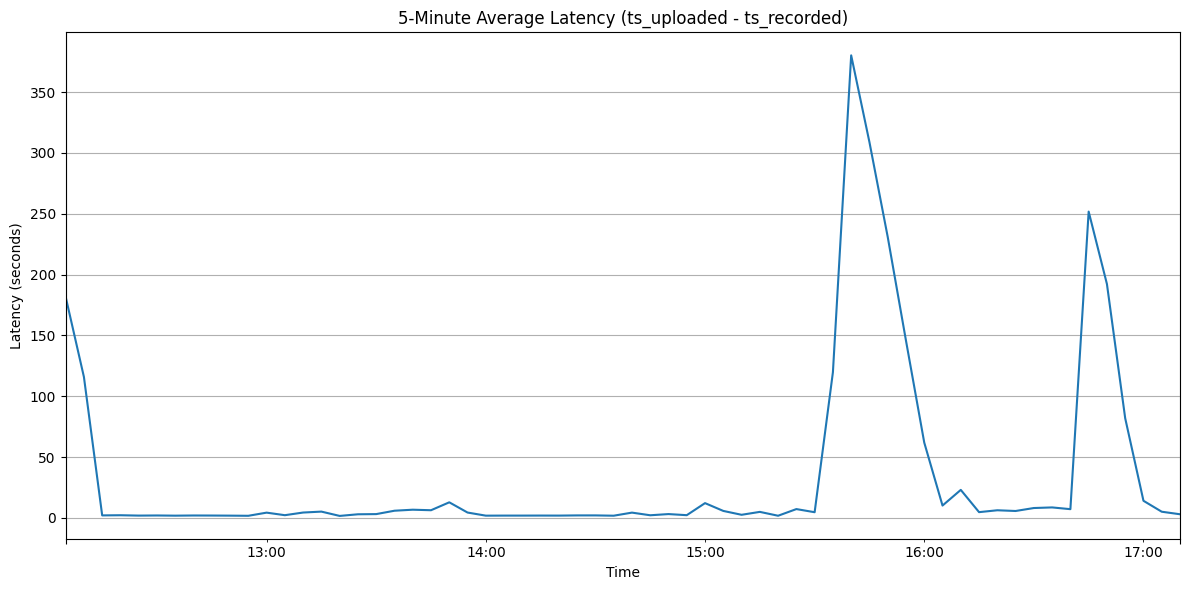

In [44]:


# Convert timestamps to datetime format
df["ts_recorded"] = pd.to_datetime(df["ts_recorded"], utc=True)
df["ts_uploaded"] = pd.to_datetime(df["ts_uploaded"], utc=True)

# Compute latency in seconds
df["latency_sec"] = (df["ts_uploaded"] - df["ts_recorded"]).dt.total_seconds()

# Set ts_recorded as the index for time-based operations
df.set_index("ts_recorded", inplace=True)

# Compute 5-minute average latency
latency_5min_avg = df["latency_sec"].resample("5min").mean()

# Plot the 5-minute average latency
plt.figure(figsize=(12, 6))
latency_5min_avg.plot()
plt.title("5-Minute Average Latency (ts_uploaded - ts_recorded)")
plt.xlabel("Time")
plt.ylabel("Latency (seconds)")
plt.grid(True)
plt.tight_layout()
plt.show()

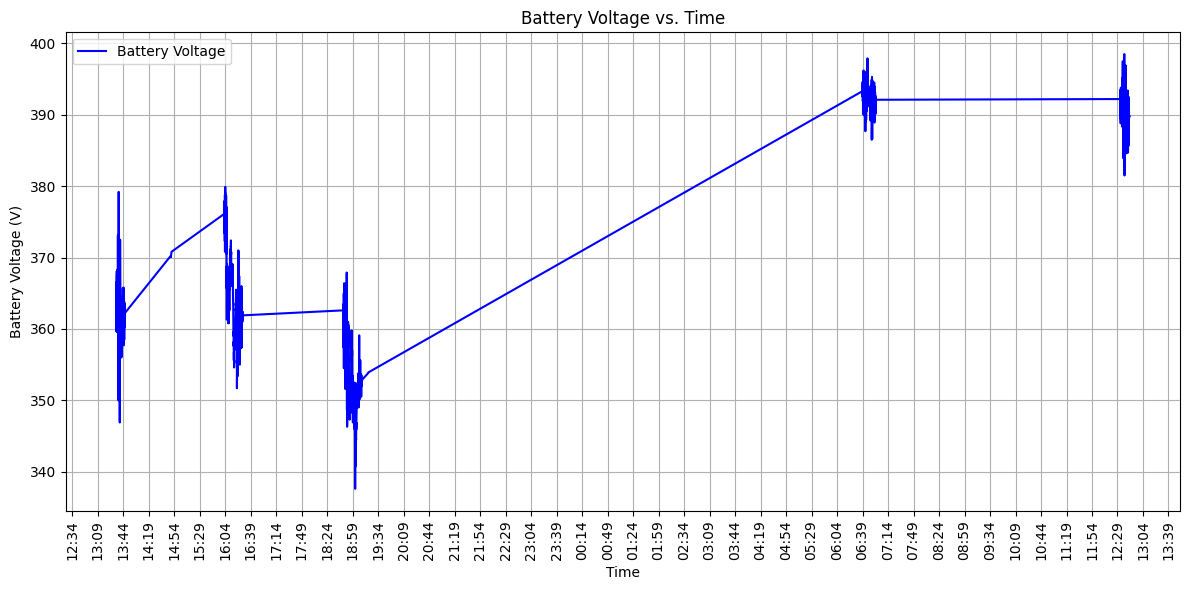

In [ ]:
# # Convert the 'ts' column to datetime
# df['ts'] = pd.to_datetime(df['ts'])

# # Plotting
# plt.figure(figsize=(12, 6))
# plt.plot(df['ts'], df['value'], label="Battery Voltage", color='blue')

# # Set x-axis to display time labels every 15 minutes without the year
# plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=35))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# # Rotate x labels for clarity
# plt.xlabel('Time')
# plt.xticks(rotation=90)

# # Y-axis and other plot elements
# plt.ylabel('Battery Voltage (V)')
# plt.title('Battery Voltage vs. Time')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()